In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import csv
import umap
import scanpy as sc

In [2]:
import h5py
from scipy.sparse import csr_matrix

def load_data(dataset,gene_percent_cells=0.01,peak_percent_cells=0.001,include_h5=True,
              preprocess=True,sampling=None,distance=1000000):
    
    data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)

    if sampling == 'geosketch':
        rna_adata = sc.read(os.path.join(data_dir,'{}.rna.sketch.h5ad'.format(dataset)))
        atac_adata = sc.read(os.path.join(data_dir,'{}.atac.sketch.h5ad'.format(dataset)))
    elif sampling == 'uniform':
        rna_adata = sc.read(os.path.join(data_dir,'{}.rna.uniform.h5ad'.format(dataset)))
        atac_adata = sc.read(os.path.join(data_dir,'{}.atac.uniform.h5ad'.format(dataset)))        
    else:
        rna_adata = sc.read(os.path.join(data_dir,'{}.rna.h5ad'.format(dataset)))
        atac_adata = sc.read(os.path.join(data_dir,'{}.atac.h5ad'.format(dataset)))

    if dataset == 'sci_car':
        data_dir = '/data/cb/alexwu/mm_finemap/data/sci_car'
        adata = sc.read(os.path.join(data_dir,'adata-hs.h5ad'))

        atac_adata.var['chr_no'] = ['chr' + n for n in atac_adata.var['chr_no']]
        atac_adata.var['start'] = adata.uns['atac.var'][:,2].astype(int)
        atac_adata.var['end'] = adata.uns['atac.var'][:,3].astype(int)

    if preprocess:
        # scale by maximum 
        # (rna already normalized by library size + log-transformed)
        X_max = rna_adata.X.max(0).toarray().squeeze()
        X_max[X_max == 0] = 1
        rna_adata.X = csr_matrix(rna_adata.X / X_max)

        # atac: normalize library size + log transformation
        sc.pp.normalize_total(atac_adata,target_sum=1e4)
        sc.pp.log1p(atac_adata)

    if include_h5:
        data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)
        with h5py.File(os.path.join(data_dir,'dataset.h5'),'r') as f:
            print(f.keys())
            data_df = pd.DataFrame()
            for k in ['chr_no','eqtl','hic','dist','atac_id','gene','corr','group_corr','gene_percent_cells',
                      'peak_percent_cells','hg38tohg19_eqtl','eqtl.new','corr_bin','group_corr_bin',
                      'hic_0hr','hic_1hr','hic_4hr','eqtl.q','hic_4hr.expectedBL','eqtl.all','hic.new2',
                      'hic.100kb','ABC.score','eqtl.fdr']: #,
#                      'hic_0hr.expectedBL','hic_1hr.expectedBL','hic_4hr.expectedBL.new','hic_0hr.expectedBL.new',
#                      'hic_4hr.expectedBL.new2','hic_12hr.expectedBL','hic_4hr.expectedBL.full']:
                if k in f.keys():
                    data_df[k] = f[k][:]

        small_df = data_df[abs(data_df['dist']) < distance]

        # small_df = small_df[~np.isnan(small_df['group_corr'])]
        small_df = small_df[small_df['gene_percent_cells'] > gene_percent_cells]
        small_df = small_df[small_df['peak_percent_cells'] > peak_percent_cells]

        small_df.index = [(atac_idx,gene) for atac_idx,gene in small_df[['atac_id','gene']].values]
    
        return rna_adata,atac_adata,small_df

    else:
        
        return rna_adata,atac_adata

In [3]:
from scipy.stats import rankdata

def load_results(dataset,eval_df,ensemble=False,gene_percent_cells=0.01,peak_percent_cells=0.001):
    
    n_layers = 10
    n_neighbors = 15
    mode = 'lr'

    eval_df['ABC.score'] = eval_df['ABC.score'].replace(np.nan, 0)
    eval_df['ABC.score'] = eval_df['ABC.score'].values #.astype(bool).astype(float)

    eval_df['corr'] = eval_df['corr'].replace(np.nan, 0)
    eval_df['group_corr'] = eval_df['group_corr'].replace(np.nan, 0)

    data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)

    
    if dataset in ['sci_car','snare_seq']:
        
        method = 'graph'
        data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)
        for trial_no in range(1,6):

            file_name = 'graph.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
            scores = pd.read_csv(os.path.join(data_dir,file_name),sep='\t').values[:,2].astype(float)
            scores[np.isinf(scores)] = 10**10
            eval_df['{}.trial{}'.format(method,trial_no)] = scores
            
    elif dataset in ['share_seq_more','human_cortex_multiome_lineage']:
        
        method = 'graph'
        for trial_no in range(1,6):

            if trial_no == 1:
                data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)
            else:
                data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}_{}'.format(dataset,trial_no)

            if dataset == 'human_cortex_multiome_lineage':
                file_name = 'graph.uniform.250kb.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
            elif dataset == 'share_seq_more':
                file_name = 'graph.uniform.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
            else:
                file_name = 'graph.uniform.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)

            scores = pd.read_csv(os.path.join(data_dir,file_name),sep='\t').values[:,2].astype(float)
            scores[np.isinf(scores)] = 10**10
            eval_df['{}.trial{}'.format(method,trial_no)] = scores
            
        
            if trial_no == 1:
                data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)
            else:
                data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}_{}'.format(dataset,trial_no)

            # correlations
            with h5py.File(os.path.join(data_dir,'dataset.h5'),'r') as f:
                data_df = pd.DataFrame()
                for k in ['dist','corr','group_corr','gene_percent_cells','peak_percent_cells']:
                    if k in f.keys():
                        data_df[k] = f[k][:]

            small_df = data_df[abs(data_df['dist']) < distance]

            # small_df = small_df[~np.isnan(small_df['group_corr'])]
            small_df = small_df[small_df['gene_percent_cells'] > gene_percent_cells]
            small_df = small_df[small_df['peak_percent_cells'] > peak_percent_cells]

            eval_df['corr.trial{}'.format(trial_no)] = small_df['corr'].replace(np.nan, 0).values
            eval_df['group_corr.trial{}'.format(trial_no)] = small_df['group_corr'].replace(np.nan, 0).values

    if ensemble:
                
        for method in ['graph','corr','group_corr']:
            eval_df['{}.ranks.mean'.format(method)] = np.array([rankdata(abs(eval_df['{}.trial{}'.format(method,trial_no)].values),
                                                                method='average') for trial_no in range(1,6)]).mean(0)

        distance_ranks = rankdata(-abs(eval_df['dist'].values),method='average')
        eval_df['dist_ranks'] = distance_ranks

        for feature in ['graph.ranks.mean','group_corr.ranks.mean','corr.ranks.mean']:
            eval_df[feature + '-dist'] = (distance_ranks + eval_df[feature].values)/2
            
    return eval_df

In [4]:
from sklearn.metrics import average_precision_score,roc_auc_score

def get_results(dataset,method,n_layers=None,n_neighbors=None,mode=None,sketch=False,trial_no=None):
    
    data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)
    
    if method == 'graph':
        trial_str = 'new2' if trial_no == 0 else 'trial{}'.format(trial_no)
        if sketch:
            file_name = 'graph.sketch.{}.all.max_scale.mseloss.{}layers.nn{}.{}.p.txt'.format(trial_str,n_layers,n_neighbors,mode)
        else:
            file_name = 'graph.{}.all.max_scale.mseloss.{}layers.nn{}.{}.p.txt'.format(trial_str,n_layers,n_neighbors,mode)
    elif method == 'granger':
        if sketch:
            file_name = 'baseline.bin.sketch.bin.results.txt'
        else:
            file_name = 'baseline.bin.bin.results.txt'
    elif method == 'graph.base':
        if sketch:
            file_name = 'graph.base.sketch.new.{}layers.nn{}.{}.txt'.format(n_layers,n_neighbors,mode)
        else:
            file_name = 'graph.base.new.{}layers.nn{}.{}.txt'.format(n_layers,n_neighbors,mode)
            
    elif method == 'gvar':
        if sketch:
            file_name = 'gvar.bin.sketch.trial{}.bin.results.txt'.format(trial_no)
        else:
            file_name = 'gvar.bin.trial{}.bin.results.txt'.format(trial_no)

    elif method == 'GVAR':
        if sketch:
            file_name = 'GVAR.bin.sketch.trial{}.bin.results.txt'.format(trial_no)
        else:
            file_name = 'GVAR.bin.trial{}.bin.results.txt'.format(trial_no)
            
    scores = pd.read_csv(os.path.join(data_dir,file_name),header=None).values
    
    if (method == 'graph' and mode == 'lr') or method == 'gvar':
        return scores
    else:
        scores[scores == 0] = 10**-100
        scores = -np.log10(scores)
        return scores
    
def print_results(eval_df,method_list,feature,thresh,direction,metric='auprc'):
    
    if direction == 'less':
        y_true = eval_df[feature].values <= thresh
    elif direction == 'greater':
        y_true = eval_df[feature].values >= thresh

    data_dict = {'method': [], metric: []}
    for method in method_list:
        scores = abs(eval_df[method].values)
                
        if metric == 'auprc':
            value = average_precision_score(y_true,scores)
        elif metric == 'auroc':
            value = roc_auc_score(y_true,scores)
            
        auprc = average_precision_score(y_true,scores)
        data_dict['method'].append(method)
        data_dict[metric].append(value)

    results_df = pd.DataFrame(data_dict)
    results_df['trial_no'] = [int(n.split('trial')[1]) if 'trial' in n else 0 for n in results_df['method']]
    results_df['method'] = [n.split('.trial')[0] for n in results_df['method']]
    
    return results_df

In [10]:
import math

def round_sigfigs(number,significant_digits=3):
    return round(number, significant_digits - int(math.floor(math.log10(abs(number)))) - 1)

def num_sigfigs(number):
    return len(str(number).split('.')[1].strip('0'))
    
def create_plot(results_df,metric):
    
    ax = sns.barplot(x='method',y=metric,hue='method',data=results_df,capsize=0.2,dodge=False)

    sns.stripplot(x='method',y=metric,hue='method',data=results_df,
                  ax=ax,color="black",size=3,alpha=0.8)

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[results_df["method"].nunique():],labels[results_df["method"].nunique():],
               bbox_to_anchor=(1,1),fontsize=16,frameon=False,handlelength=0.8)
    sns.despine()

    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

    plt.ylim(0,results_df[metric].max()*1.02)
    plt.xlabel('',fontsize=16)
    plt.ylabel(metric.upper(),fontsize=16)
    plt.yticks(fontsize=14)
    plt.xticks(rotation=90)
    
    return ax
    

In [6]:
def distance_matched_df(eval_df,feature,lower_thresh,negpos_ratio=9,seed=1,dist_min=2,verbose=True):
    
    df_copy = eval_df.copy()
    np.random.seed(1)
    
    dist_categories = np.clip(np.log10(0.1+abs(df_copy['dist'].values)).astype(int),dist_min,10)
    df_copy['dist_category'] = dist_categories

    df_list = []
    for group,group_df in df_copy.groupby('dist_category'):
        
        n_per_category = (group_df[feature] <= lower_thresh).sum()
        pos_inds = np.argsort(group_df[feature])[0:n_per_category].tolist()
        neg_inds = np.argsort(group_df[feature])[(-negpos_ratio*n_per_category):]
        neg_inds = list(set(neg_inds) - set(pos_inds))
        
        if verbose:
            print(group,len(pos_inds),len(neg_inds))
        
        df_list.append(group_df.iloc[pos_inds + neg_inds])
    
    return pd.concat(df_list)

In [7]:
def convert_name(n):
    
    if 'graph' in n:
        name = 'GrID-Net'
    elif 'group' in n:
        name = 'Pseudocell Corr'
    elif 'corr' in n:
        name = 'Correlation'
    elif 'ABC' in n:
        name = 'ABC'
    elif "GVAR" in n or "gvar" in n:
        name = "GVAR"
    elif "granger" in n:
        name = "Granger"
    elif "tripod" in n:
        name = "TRIPOD"
    
    
    if 'rra' in n:
        name += ' (RRA)'
        
    if 'ranks' in n:
        name += ' (ens)'
    
    if '-dist' in n:
        name += ' (dist)'
        

    return name

## Results

In [8]:
dataset = 'share_seq_more'

distance = 1000000
gene_percent_cells = 0.01
peak_percent_cells = 0.001

# sketch = 'glial' not in dataset
rna_adata,atac_adata,eval_df = load_data(dataset,gene_percent_cells=gene_percent_cells,
                                          peak_percent_cells=peak_percent_cells,
                                          include_h5=True,sampling='uniform',distance=distance)

eval_df = load_results(dataset,eval_df,ensemble=True)
eval_df['abs_dist'] = abs(eval_df['dist'])

Only considering the two last: ['.uniform', '.h5ad'].
Only considering the two last: ['.uniform', '.h5ad'].
Only considering the two last: ['.uniform', '.h5ad'].
Only considering the two last: ['.uniform', '.h5ad'].
<KeysViewHDF5 ['ABC.score', 'atac_id', 'chr_no', 'corr', 'corr.sketch', 'corr_bin', 'dist', 'eqtl.all', 'eqtl.fdr', 'eqtl.q', 'gene', 'gene_percent_cells', 'group_corr', 'group_corr.sketch', 'hic', 'hic.new', 'hic.new2', 'peak_percent_cells']>


In [9]:
# load standard Granger + GVAR results
dataset = 'share_seq_more'

data_dir = "/data/cb/alexwu/mm_finemap/results/tests_nn"
df = pd.read_csv(os.path.join(data_dir,dataset,"{}.standard_granger.csv".format(dataset)))
eval_df["granger.trial{}".format(1)] = -np.log10(df["granger_p"].values)
for trial_no in range(2,6):
    df = pd.read_csv(os.path.join(data_dir,"{}_{}".format(dataset,trial_no),"{}_{}.standard_granger.csv".format(dataset,trial_no)))
    eval_df["granger.trial{}".format(trial_no)] = -np.log10(df["granger_p"].values)

In [11]:
# load standard Granger + GVAR results
dataset = 'share_seq_more'

data_dir = "/data/cb/alexwu/mm_finemap/results/tests_nn"
# df = pd.read_csv(os.path.join(data_dir,dataset,"{}.GVAR.csv".format(dataset,trial_no)))
# p = [float(n.strip("[]")) for n in df["granger_p"].values]
# eval_df["gvar.trial{}".format(1)] = -np.log10(df["granger_p"].values)
for trial_no in range(2,6):
    df = pd.read_csv(os.path.join(data_dir,"{}_{}".format(dataset,trial_no),"{}_{}.GVAR.csv".format(dataset,trial_no)))
    p = [float(n.strip("[]")) for n in df["granger_p"].values]
    eval_df["gvar.trial{}".format(trial_no)] = -np.log10(p)

In [12]:
# dataset = 'share_seq_more'
# n_layers = 10
# n_neighbors = 15
# mode = 'lr'

# method = 'GVAR'
# for trial_no in range(1,4):
#     scores = get_results(dataset,method,n_layers=n_layers,n_neighbors=n_neighbors,mode=mode,trial_no=trial_no,
#                         sketch=True)
#     scores[np.isinf(scores)] = 10**10
#     eval_df['{}.trial{}'.format(method,trial_no)] = scores

# method = 'granger'
# scores = get_results(dataset,method,n_layers=n_layers,n_neighbors=n_neighbors,mode=mode,trial_no=0,sketch=True)

# scores[np.isinf(scores)] = 10**10
# eval_df[method] = scores

### No Ensembling

In [13]:
name_dict = {'graph': 'GrID-Net',
             'corr': 'Correlation',
             'group_corr': 'Pseudocell Corr',
             'ABC.score': 'ABC',
             'granger': "Linear GC",
             'gvar': "GVAR"}

data_dir = '/data/cb/alexwu/mm_finemap/data/share_seq/validation'

df = pd.read_csv(os.path.join(data_dir,'GSM2740038_5C-pKerat-R1-zscore-pval-qval.txt.gz'),
                 sep='\t',compression='gzip',header=None)
hic_lower_thresh = -df.values[:,6][df.values[:,8] < 1e-3].min()

In [14]:
eqtl_lower_thresh = 1e-10
eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])].copy()

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]
eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.q',eqtl_lower_thresh,negpos_ratio=1,seed=1)

eval_df_hic = eval_df[~np.isnan(eval_df['hic.new2'])].copy()
eval_df_hic['hic.new2.rev'] = -eval_df_hic['hic.new2'].values
# eval_df_hic = eval_df_hic[abs(eval_df_hic['dist']) > 50000]
# hic_lower_thresh = -np.percentile(eval_df_hic['hic.new2'],99)
eval_df_hic = distance_matched_df(eval_df_hic,'hic.new2.rev',hic_lower_thresh,negpos_ratio=1,seed=1,dist_min=5)

2 12 12
3 7 7
4 47 47
5 12 12
5 124 124


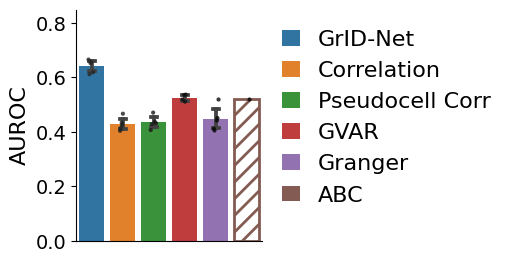

In [15]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['group_corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['gvar.trial{}'.format(trial_no) for trial_no in range(2,6)]
method_list += ['granger.trial{}'.format(trial_no) for trial_no in range(1,6)]

method_list += ['ABC.score'] #,'dist_ranks']

feature = 'eqtl.all'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

results_df['method'] = [convert_name(n) for n in results_df['method']]
plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)
plt.rcParams['hatch.linewidth'] = 2
ax.patches[-1].set_edgecolor(ax.patches[-1]._facecolor)
ax.patches[-1].set_facecolor('white')
ax.patches[-1].set_hatch('//')
ax.patches[-1].set_linewidth(2)
    
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
# plt.legend(bbox_to_anchor=(1,1),fontsize=16,frameon=False,handlelength=0.8)
# sns.despine()

plt.ylim([0,0.85])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','updated.{}.eqtl.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
plt.show()

In [27]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['group_corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['gvar.trial{}'.format(trial_no) for trial_no in range(2,6)]
method_list += ['granger.trial{}'.format(trial_no) for trial_no in range(1,6)]

method_list += ['ABC.score'] #,'dist_ranks']

feature = 'eqtl.all'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

results_df['method'] = [convert_name(n) for n in results_df['method']]

In [30]:
results_df.groupby("method")["auroc"].mean()

method
ABC                0.519395
Correlation        0.428632
GVAR               0.525559
GrID-Net           0.641206
Granger            0.445480
Pseudocell Corr    0.434681
Name: auroc, dtype: float64

In [31]:
(0.641206-0.525559)/0.525559

0.2200457037173753

In [77]:
from scipy.stats import ttest_ind

for method in ["Correlation","Pseudocell Corr","GVAR","Granger"]:
    print(method)
    print(ttest_ind(results_df[results_df["method"] == "GrID-Net"]["auroc"],
          results_df[results_df["method"] == method]["auroc"],
          equal_var=False,alternative='greater'))
    print('------')

Correlation
Ttest_indResult(statistic=13.938134066804283, pvalue=3.3997852725633653e-07)
------
Pseudocell Corr
Ttest_indResult(statistic=13.814997119010076, pvalue=3.7037996079813053e-07)
------
GVAR
Ttest_indResult(statistic=9.24274394446773, pvalue=3.6031097846733226e-05)
------
Granger
Ttest_indResult(statistic=8.520414902115892, pvalue=6.558356077479193e-05)
------


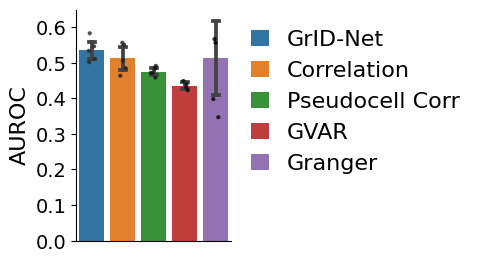

In [16]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['group_corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['gvar.trial{}'.format(trial_no) for trial_no in range(2,6)]
method_list += ['granger.trial{}'.format(trial_no) for trial_no in range(1,6)]

method_list += ['ABC.score'] #,'dist_ranks']

feature = 'hic.new2.rev'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_hic,method_list,feature,hic_lower_thresh,direction,metric=metric)
results_df['method'] = [convert_name(n) for n in results_df['method']]
results_df = results_df[results_df['method'] != 'ABC']

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)

plt.ylim([0,0.65])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','updated.{}.hic.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
plt.show()

In [79]:
from scipy.stats import ttest_ind

for method in ["Correlation","Pseudocell Corr","GVAR","Granger"]:
    print(method)
    print(ttest_ind(results_df[results_df["method"] == "GrID-Net"]["auroc"],
          results_df[results_df["method"] == method]["auroc"],
          equal_var=False,alternative='greater'))
    print('------')

Correlation
Ttest_indResult(statistic=0.9760549455092846, pvalue=0.17952758431462681)
------
Pseudocell Corr
Ttest_indResult(statistic=3.8650402720535273, pvalue=0.0054540386571077055)
------
GVAR
Ttest_indResult(statistic=6.438352237595719, pvalue=0.0005955500056958426)
------
Granger
Ttest_indResult(statistic=0.3305603995833492, pvalue=0.37804377159804825)
------


#### Intersection of eQTLs & Hi-C

In [17]:
eqtl_lower_thresh = 1e-1
eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])].copy()

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]
# eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.q',eqtl_lower_thresh,negpos_ratio=1,seed=1)

eval_df_hic = eval_df[~np.isnan(eval_df['hic.new2'])].copy()
eval_df_hic['hic.new2.rev'] = -eval_df_hic['hic.new2'].values
# eval_df_hic = eval_df_hic[abs(eval_df_hic['dist']) > 50000]
# hic_lower_thresh = -np.percentile(eval_df_hic['hic.new2'],99)
# eval_df_hic = distance_matched_df(eval_df_hic,'hic.new2.rev',hic_lower_thresh,negpos_ratio=1,seed=1,dist_min=5)

In [18]:
set(eval_df_hic.index.values) & set(eval_df_eqtl.index.values)

{(185901.0, b'Rorc')}

### eQTL (1e-3)

2 29 29
3 30 30
4 140 140
5 51 51
5 124 124


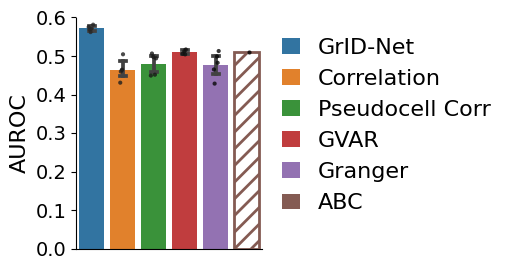

Correlation
Ttest_indResult(statistic=8.789841209559679, pvalue=0.00023912584900206792)
------
Pseudocell Corr
Ttest_indResult(statistic=7.285173853510287, pvalue=0.0005608189484506242)
------
GVAR
Ttest_indResult(statistic=14.084494281647768, pvalue=1.1192327695978894e-06)
------
Granger
Ttest_indResult(statistic=6.267982740317527, pvalue=0.001207072896216058)
------


In [19]:
eqtl_lower_thresh = 1e-3
eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])].copy()

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]
eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.q',eqtl_lower_thresh,negpos_ratio=1,seed=1)

eval_df_hic = eval_df[~np.isnan(eval_df['hic.new2'])].copy()
eval_df_hic['hic.new2.rev'] = -eval_df_hic['hic.new2'].values
# eval_df_hic = eval_df_hic[abs(eval_df_hic['dist']) > 50000]
# hic_lower_thresh = -np.percentile(eval_df_hic['hic.new2'],99)
eval_df_hic = distance_matched_df(eval_df_hic,'hic.new2.rev',hic_lower_thresh,negpos_ratio=1,seed=1,dist_min=5)

method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['group_corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['gvar.trial{}'.format(trial_no) for trial_no in range(2,6)]
method_list += ['granger.trial{}'.format(trial_no) for trial_no in range(1,6)]

method_list += ['ABC.score'] #,'dist_ranks']

feature = 'eqtl.all'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

results_df['method'] = [convert_name(n) for n in results_df['method']]
plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)
plt.rcParams['hatch.linewidth'] = 2
ax.patches[-1].set_edgecolor(ax.patches[-1]._facecolor)
ax.patches[-1].set_facecolor('white')
ax.patches[-1].set_hatch('//')
ax.patches[-1].set_linewidth(2)

plt.ylim([0,0.6])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','updated.{}.eqtl.1e-3.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
plt.show()

from scipy.stats import ttest_ind

for method in ["Correlation","Pseudocell Corr","GVAR","Granger"]:
    print(method)
    print(ttest_ind(results_df[results_df["method"] == "GrID-Net"]["auroc"],
          results_df[results_df["method"] == method]["auroc"],
          equal_var=False,alternative='greater'))
    print('------')

### Robustness

#### Number of Highly Variable Genes

In [20]:
method = 'graph'
n_layers = 10
n_neighbors = 15
for trial_no in range(1,6):

    if trial_no == 1:
        data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)
    else:
        data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}_{}'.format(dataset,trial_no)

    if dataset == 'human_cortex_multiome_lineage':
        file_name = 'graph.uniform.250kb.hv4000.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
    elif dataset == 'share_seq_more':
        file_name = 'graph.uniform.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
    else:
        file_name = 'graph.uniform.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)

    scores = pd.read_csv(os.path.join(data_dir,file_name),sep='\t').values[:,2].astype(float)
    scores[np.isinf(scores)] = 10**10
    eval_df['{}.hv4000.trial{}'.format(method,trial_no)] = scores

#### Number of Neighbors

In [21]:
method = 'graph'
n_layers = 10
for trial_no in range(1,6):
    
    for n_neighbors in [5,25]:

        if trial_no == 1:
            data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)
        else:
            data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}_{}'.format(dataset,trial_no)

        if dataset == 'human_cortex_multiome_lineage':
            file_name = 'graph.uniform.250kb.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
        elif dataset == 'share_seq_more':
            file_name = 'graph.uniform.1Mb.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
        else:
            file_name = 'graph.uniform.1Mb.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)

        scores = pd.read_csv(os.path.join(data_dir,file_name),sep='\t').values[:,2].astype(float)
        scores[np.isinf(scores)] = 10**10
        eval_df['{}.nn{}.trial{}'.format(method,n_neighbors,trial_no)] = scores

#### Plots

In [22]:
name_dict = {'graph': 'GrID-Net',
             'corr': 'Correlation',
             'group_corr': 'Pseudocell Corr',
             'ABC.score': 'ABC',
             'granger': "Linear GC",
             'gvar': "GVAR"}

data_dir = '/data/cb/alexwu/mm_finemap/data/share_seq/validation'

df = pd.read_csv(os.path.join(data_dir,'GSM2740038_5C-pKerat-R1-zscore-pval-qval.txt.gz'),
                 sep='\t',compression='gzip',header=None)
hic_lower_thresh = -df.values[:,6][df.values[:,8] < 1e-3].min()

In [23]:
eqtl_lower_thresh = 1e-10
eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])].copy()

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]
eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.q',eqtl_lower_thresh,negpos_ratio=1,seed=1)

eval_df_hic = eval_df[~np.isnan(eval_df['hic.new2'])].copy()
eval_df_hic['hic.new2.rev'] = -eval_df_hic['hic.new2'].values
# eval_df_hic = eval_df_hic[abs(eval_df_hic['dist']) > 50000]
# hic_lower_thresh = -np.percentile(eval_df_hic['hic.new2'],99)
eval_df_hic = distance_matched_df(eval_df_hic,'hic.new2.rev',hic_lower_thresh,negpos_ratio=1,seed=1,dist_min=5)

2 12 12
3 7 7
4 47 47
5 12 12
5 124 124


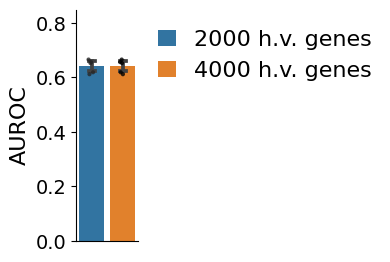

In [24]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.hv4000.trial{}'.format(trial_no) for trial_no in range(1,6)]

feature = 'eqtl.all'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

results_df['method'] = ["2000 h.v. genes" if "hv" not in n else "4000 h.v. genes" for n in results_df['method']] # [convert_name(n) for n in results_df['method']]
plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)
# plt.rcParams['hatch.linewidth'] = 2
# ax.patches[-1].set_edgecolor(ax.patches[-1]._facecolor)
# ax.patches[-1].set_facecolor('white')
# ax.patches[-1].set_hatch('//')
# ax.patches[-1].set_linewidth(2)

plt.ylim([0,0.85])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','updated.{}.robustness.hv_genes.eqtl.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
plt.show()

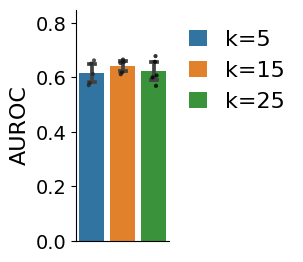

In [25]:
method_list = ['graph.nn5.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.nn25.trial{}'.format(trial_no) for trial_no in range(1,6)]

feature = 'eqtl.all'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

results_df['method'] = ["k={}".format(n.split(".nn")[1]) if "nn" in n else "k=15" 
                        for n in results_df['method']]

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)

plt.ylim([0,0.85])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.robustness.n_neighbors.eqtl.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
plt.show()

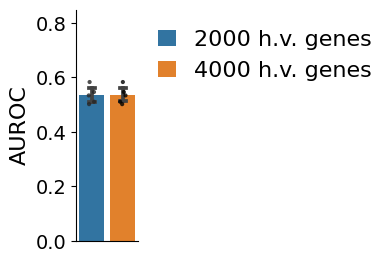

In [26]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.hv4000.trial{}'.format(trial_no) for trial_no in range(1,6)]

feature = 'hic.new2.rev'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_hic,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

results_df['method'] = ["2000 h.v. genes" if "hv" not in n else "4000 h.v. genes" for n in results_df['method']] # [convert_name(n) for n in results_df['method']]
plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)
# plt.rcParams['hatch.linewidth'] = 2
# ax.patches[-1].set_edgecolor(ax.patches[-1]._facecolor)
# ax.patches[-1].set_facecolor('white')
# ax.patches[-1].set_hatch('//')
# ax.patches[-1].set_linewidth(2)

plt.ylim([0,0.85])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','updated.{}.robustness.hv_genes.hic.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
plt.show()

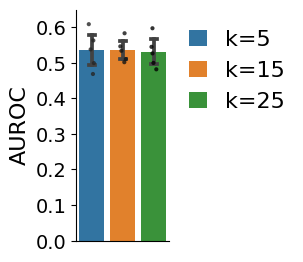

In [27]:
method_list = ['graph.nn5.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.nn25.trial{}'.format(trial_no) for trial_no in range(1,6)]

feature = 'hic.new2.rev'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_hic,method_list,feature,hic_lower_thresh,direction,metric=metric)
results_df['method'] = ["k={}".format(n.split(".nn")[1]) if "nn" in n else "k=15" 
                        for n in results_df['method']]
results_df = results_df[results_df['method'] != 'ABC']

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)

plt.ylim([0,0.65])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','updated.{}.robustness.n_neighbors.hic.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
plt.show()

### Sparse Genes, Peaks
#### Sparse Genes

In [11]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['group_corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['gvar.trial{}'.format(trial_no) for trial_no in range(2,6)]
method_list += ['granger.trial{}'.format(trial_no) for trial_no in range(1,6)]

# method_list += ['ABC.score'] #,'dist_ranks']

In [12]:
results_df_list = []
eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])].copy()

# method_list = ['{}.trial{}'.format(method,trial_no) for method in ['graph','corr','group_corr'] for trial_no in range(1,6)]

for bin_start,bin_end in [(0.,0.1),(0.1,0.2),(0.2,0.5)]:

    eqtl_lower_thresh = 1e-10
    eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])].copy()

    # FDR correction
    from statsmodels.stats.multitest import fdrcorrection
    eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]
        
    eval_df_eqtl = eval_df_eqtl[(eval_df_eqtl['gene_percent_cells'] > bin_start) & (eval_df_eqtl['gene_percent_cells'] < bin_end)]
    eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.all',eqtl_lower_thresh,negpos_ratio=1,seed=1,verbose=False)
    
    feature = 'eqtl.all'
    direction = 'less'

    metric = 'auroc'
    results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

    results_df['method'] = [convert_name(n) for n in results_df['method']]
    results_df['percent_cells'] = ["{:.0f} - {:.0f}%".format(100*bin_start,100*bin_end) for i in range(results_df.shape[0])]
    results_df_list.append(results_df)
results_df = pd.concat(results_df_list)

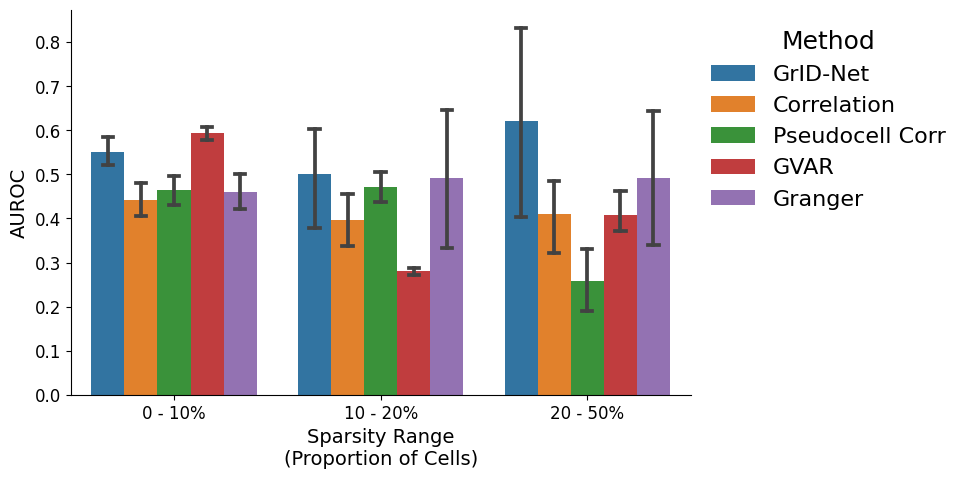

In [14]:
plot_dir = '/data/cb/alexwu/mm_finemap/figures'

plt.figure(figsize=(8,5))
sns.barplot(x="percent_cells",y="auroc",hue="method",data=results_df,capsize=0.05)
plt.xlabel("Sparsity Range\n(Proportion of Cells)",fontsize=14)
plt.ylabel("AUROC",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=16,bbox_to_anchor=(1,1),title='Method',title_fontsize=18,frameon=False)
sns.despine()
plt.savefig(os.path.join(plot_dir,'auroc','updated.{}.sparsity_genes.eqtl.0524.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
plt.show()

#### Sparse Peaks

In [16]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['group_corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['gvar.trial{}'.format(trial_no) for trial_no in range(2,6)]
method_list += ['granger.trial{}'.format(trial_no) for trial_no in range(1,6)]

# method_list += ['ABC.score'] #,'dist_ranks']

In [17]:
# method_list = ["{}.trial{}".format(method,trial_no) for method in ['graph','corr','group_corr'] for trial_no in range(1,6)]

results_df_list = []
# eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])].copy()
for bin_start,bin_end in [(0.,0.01),(0.01,0.05),(0.05,0.1)]:

    eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])].copy()
    
    # FDR correction
    from statsmodels.stats.multitest import fdrcorrection
    eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]

    eval_df_eqtl = eval_df_eqtl[(eval_df_eqtl['peak_percent_cells'] > bin_start) & (eval_df_eqtl['peak_percent_cells'] < bin_end)]
    eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.all',eqtl_lower_thresh,negpos_ratio=1,seed=1,verbose=False)
    
    feature = 'eqtl.all'
    direction = 'less'

    metric = 'auroc'
    results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

    results_df['method'] = [convert_name(n) for n in results_df['method']]
    results_df['percent_cells'] = ["{:.0f} - {:.0f}%".format(100*bin_start,100*bin_end) for i in range(results_df.shape[0])]
    results_df_list.append(results_df)
results_df = pd.concat(results_df_list)

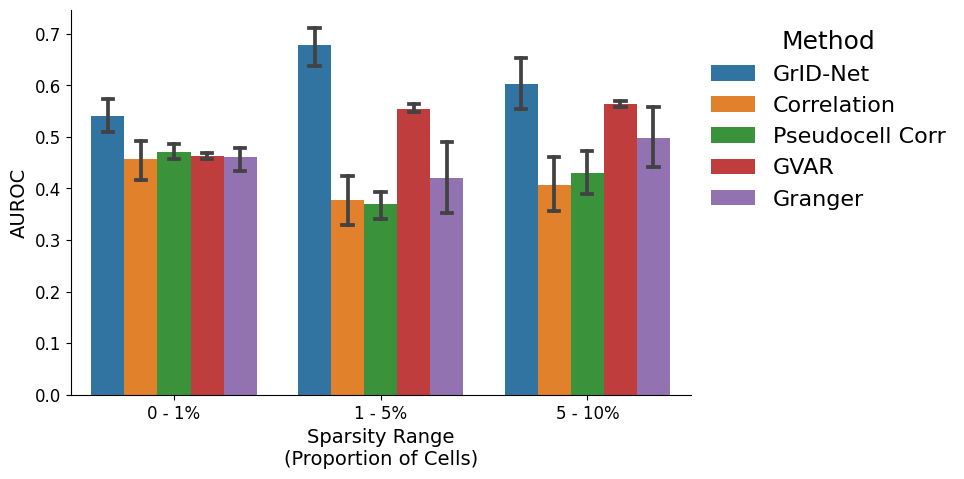

In [18]:
plot_dir = '/data/cb/alexwu/mm_finemap/figures'

plt.figure(figsize=(8,5))
sns.barplot(x="percent_cells",y="auroc",hue="method",data=results_df,capsize=0.05)
plt.xlabel("Sparsity Range\n(Proportion of Cells)",fontsize=14)
plt.ylabel("AUROC",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=16,bbox_to_anchor=(1,1),title='Method',title_fontsize=18,frameon=False)
sns.despine()
plt.savefig(os.path.join(plot_dir,'auroc','updated.{}.sparsity_peaks.eqtl.0524.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
plt.show()

## Logistic Regression: Include Distance

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score,roc_auc_score

def nested_cross_validation_datasets(eval_df,feature,lower_thresh,negpos_ratio,n_folds=3,dist_min=2,seed=1):
    
    df_copy = eval_df.copy()
    
    dist_categories = np.clip(np.log10(0.1+abs(df_copy['dist'].values)).astype(int),dist_min,10)
    df_copy['dist_category'] = dist_categories
    df_copy['label'] = (df_copy[feature] < lower_thresh).values.astype(float)
    
    df_list = []
    for group,group_df in df_copy.groupby(['dist_category','label']):
        group_df['fold'] = np.arange(group_df.shape[0]) % n_folds
        df_list.append(group_df)
    df = pd.concat(df_list)
    
    # validation set
    validation_df = df[df['fold'] == 0]
    inner_df = df[df['fold'] != 0]
    
    # inner loop training, test sets
    inner_df_list = []
    for group,group_df in inner_df.groupby(['dist_category','label']):
        group_df['fold'] = np.arange(group_df.shape[0]) % n_folds
        inner_df_list.append(group_df)
    inner_df = pd.concat(inner_df_list)
        
    inner_df_sets = []
    for fold_no in range(n_folds):
        test_df = inner_df[inner_df['fold'] == fold_no]
        train_df = inner_df[inner_df['fold'] != fold_no]
    
        inner_df_sets.append((train_df,test_df))
        
    return validation_df,inner_df_sets

def transform_X(df,score_key):

#     X = df[[score_key,'log_dist']].values
    X = np.array([np.log(1e-10+df[score_key]),np.clip(np.log10(1+df['abs_dist']),4,10)-4]).T

#     X = np.log10(1e-5 + df[[score_key,'abs_dist']].values)

    return X

def nested_cross_validation(inner_df_sets,score_key,feature,lower_thresh,metric='auroc'):
    
    model_list = []
    metric_list = []
    
    for train_df,test_df in inner_df_sets:
                
        train_X = transform_X(train_df,score_key)
        train_y = (train_df[feature] < lower_thresh).astype(float)
        
        test_X = transform_X(test_df,score_key)
        test_y = (test_df[feature] < lower_thresh).astype(float)

        lr = LogisticRegression(penalty='none',fit_intercept=True).fit(train_X,train_y)
        
        if metric == 'auroc':
            metric_list.append(roc_auc_score(test_y,lr.predict_proba(test_X)[:,1]))
        elif metric == 'auprc':
            metric_list.append(average_precision_score(test_y,lr.predict_proba(test_X)[:,1]))
        
        model_list.append(lr)
        
    return model_list[np.argmax(metric_list)]

def validation_predictions(validation_df,selected_model,score_key,feature,lower_thresh):
    
    validation_X = transform_X(validation_df,score_key)
    validation_y = (validation_df[feature] < lower_thresh).astype(float)

    validation_df[score_key + '-dist-LR'] = selected_model.predict_proba(validation_X)[:,1]

In [62]:
# for col in eval_df.columns:
#     if 'ranks.mean' in col:
#         eval_df[col + '.rerank'] = rankdata(eval_df[col],method='average')

In [70]:
eqtl_lower_thresh = 1e-10
eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])].copy()

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]

eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.q',eqtl_lower_thresh,negpos_ratio=1,seed=1)

# # min-max normalize rankings
# for col in eval_df_eqtl.columns:
#     if 'ranks.mean' in col:
#         min_value = eval_df[col].min()
#         max_value = eval_df[col].max()
#         eval_df_eqtl['{}.norm'.format(col)] = np.log(1+(eval_df_eqtl[col] - min_value)/(max_value-min_value))

2 12 12
3 7 7
4 47 47
5 12 12


In [71]:
n_folds = 3
feature = 'eqtl.q'
negpos_ratio = 1
direction = 'less'

validation_df,inner_df_sets = nested_cross_validation_datasets(eval_df_eqtl,feature,eqtl_lower_thresh,
                                                              negpos_ratio,n_folds=n_folds,seed=1)

# method_list = ['graph.ranks.mean.norm','group_corr.ranks.mean.norm','corr.ranks.mean.norm']
method_list = ['{}.ranks.mean'.format(method) for method in ['graph','corr','group_corr']]

for score_key in method_list:
    selected_lr = nested_cross_validation(inner_df_sets,score_key,feature,eqtl_lower_thresh)
    print(score_key,selected_lr.coef_,selected_lr.intercept_)
    validation_predictions(validation_df,selected_lr,score_key,feature,eqtl_lower_thresh)

graph.ranks.mean [[ 0.77661531 -0.47272459]] [-10.50656008]
corr.ranks.mean [[-2.02137031 -0.73724918]] [29.05684741]
group_corr.ranks.mean [[-0.34702563 -0.54205462]] [5.22982929]


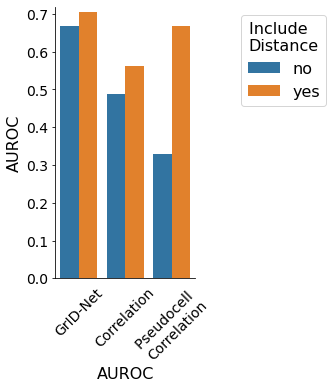

In [72]:
# method_list = ['graph.ranks.mean','group_corr.ranks.mean','corr.ranks.mean']
method_list = ['{}.ranks.mean'.format(method) for method in ['graph','corr','group_corr']]
method_list += ['{}-dist-LR'.format(n) for n in method_list]

metric = 'auroc'
results_df = print_results(validation_df,method_list,feature,eqtl_lower_thresh,direction,metric=metric)
results_df['method'] = [convert_name(n) for n in results_df['method']]

results_df['dist'] = ['yes' if '(dist)' in n else 'no' for n in results_df['method']]
results_df['method'] = [n.split(' (')[0] for n in results_df['method']]
results_df['method'] = ['Pseudocell \nCorrelation' if 'Pseudo' in n else n for n in results_df['method']]

plt.figure(figsize=(2.5,5))
sns.barplot(x='method',y=metric,hue='dist',data=results_df,capsize=0.1,dodge=True)
plt.ylim(0,results_df[metric].max()*1.02)
plt.xlabel(metric.upper(),fontsize=16)
plt.ylabel(metric.upper(),fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14,rotation=45)
    
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.legend(bbox_to_anchor=(2,1),fontsize=16,title='Include \nDistance',title_fontsize=16,frameon=True)
sns.despine()

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.LR-dist.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
plt.show()

### Determine Optimal Threshold (as Percentile of all Peak-Gene Pairs)
#### Compute Distance-based GrID-Net Scores for all Peak-Gene Pairs

In [14]:
from sklearn.linear_model import LogisticRegression

def transform_X(df,score_key):

#     X = df[[score_key,'log_dist']].values
    X = np.array([np.log(1e-10+df[score_key]),np.clip(np.log10(1+df['abs_dist']),4,10)-4]).T
#     X = np.log10(1e-5 + df[[score_key,'abs_dist']].values)

    return X

def string2coeffs(coeff_str):
    
    values = np.array([float(v) for v in [n.strip('[ ]') 
                        for n in coeff_str.split(' ')] if len(v)])
    
    return np.array([values[0:2]]),np.array([values[2]])

lr = LogisticRegression(penalty='none',fit_intercept=True)

coeff_str = '[[ 0.28332471 -0.16272753]] [-3.66021169]'
coeff_str = '[[ 0.77661531 -0.47272459]] [-10.50656008]'

lr.coef_,lr.intercept_ = string2coeffs(coeff_str)
lr.classes_ = np.array([0,1])

score_key = 'graph.ranks.mean'
X = transform_X(eval_df,score_key)

eval_df['{}-LR-dist'.format(score_key)] = lr.predict_proba(X)[:,1]

#### Evaluate Percentile of Scores (Relative to all Peak-Gene Scores)

In [15]:
from sklearn.metrics import f1_score

# less than 250kb
filtered_validation_df = validation_df[abs(validation_df['dist']) < 250000]
filtered_eval_df = eval_df[abs(eval_df['dist']) < 250000]

percentile_list = []
score_list = []
f1_score_list = []
precision_list = []
recall_list = []
for score in sorted(filtered_validation_df['graph.ranks.mean-dist-LR']):
    y_true = (filtered_validation_df[feature] < eqtl_lower_thresh).astype(float)
    y_pred = (filtered_validation_df['graph.ranks.mean-dist-LR'] >= score).astype(float)
    
    percentile_list.append((filtered_eval_df['{}-LR-dist'.format(score_key)] < score).mean())
    score_list.append(score)
    f1_score_list.append(f1_score(y_true, y_pred))
    precision_list.append((y_true + y_pred == 2).sum()/sum(y_pred))
    recall_list.append((y_true + y_pred == 2).sum()/sum(y_true))

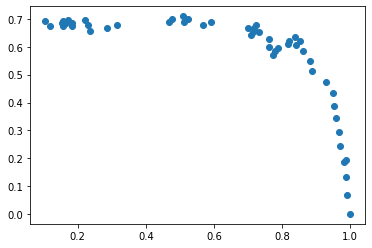

In [23]:
plt.scatter(percentile_list,f1_score_list)
plt.show()

In [19]:
print('Score for Optimal F1:\t',np.array(score_list)[np.argmax(f1_score_list)])
print('Optimal F1:\t\t',max(f1_score_list))

Score for Optimal F1:	 0.5119947260150817
Optimal F1:		 0.7096774193548386


In [20]:
print('Percentile of Score for Optimal F1:\t',np.array(percentile_list)[np.argmax(f1_score_list)])

Percentile of Score for Optimal F1:	 0.5103393526548252


In [21]:
print('Recall of Score for Optimal F1:\t',np.array(recall_list)[np.argmax(f1_score_list)])

Recall of Score for Optimal F1:	 0.8148148148148148


In [22]:
print('Precision of Score for Optimal F1:\t',np.array(precision_list)[np.argmax(f1_score_list)])

Precision of Score for Optimal F1:	 0.6285714285714286


## TRIPOD Comparison

### Aggregate TRIPOD Results

In [28]:
atac_df = atac_adata.var.copy()
atac_df["peak"] = ["{}-{}-{}".format(chr_no,start,end) for chr_no,start,end in atac_adata.var.values]

In [29]:
data_dir = "/data/cb/alexwu/mm_finemap/tools/TRIPOD/scripts/share_seq_skin"

pred_df_list = []
for name in ["X1","X2","Y1","Y2"]:
    filename = "xymats.t{}.pos.df.csv".format(name)

    df = pd.read_csv(os.path.join(data_dir,filename))

    peak_df = df[["peak_num","peak"]].drop_duplicates()
    peak_df.index = peak_df["peak"].values

    peak_to_idx_dict = {n:i for i,n in enumerate(atac_df["peak"].values)}
    df["atac_id"] = [peak_to_idx_dict[peak] for peak in df["peak"].values]
    pred_df_list.append(df)

In [30]:
pred_df = pd.concat(pred_df_list)

In [31]:
summary_df = pred_df[["gene","atac_id","adj"]].groupby(["gene","atac_id"]).min().reset_index()

In [32]:
peak_gene_tripod_dict = {(peak,gene): -np.log10(p) if p != 0 else 1000
                         for peak,gene,p in summary_df[["atac_id","gene","adj"]].values}

In [33]:
eval_df["tripod"] = [peak_gene_tripod_dict[(int(peak),gene.decode())] if (int(peak),gene.decode()) in peak_gene_tripod_dict else 0 
                     for peak,gene in eval_df[["atac_id","gene"]].values]

In [34]:
name_dict = {'graph': 'GrID-Net',
             'corr': 'Correlation',
             'group_corr': 'Pseudocell Corr',
             'ABC.score': 'ABC',
             'granger': "Linear GC",
             'gvar': "GVAR"}

data_dir = '/data/cb/alexwu/mm_finemap/data/share_seq/validation'

df = pd.read_csv(os.path.join(data_dir,'GSM2740038_5C-pKerat-R1-zscore-pval-qval.txt.gz'),
                 sep='\t',compression='gzip',header=None)
hic_lower_thresh = -df.values[:,6][df.values[:,8] < 1e-3].min()

eqtl_lower_thresh = 1e-10
eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])].copy()

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]
eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.q',eqtl_lower_thresh,negpos_ratio=1,seed=1)

eval_df_hic = eval_df[~np.isnan(eval_df['hic.new2'])].copy()
eval_df_hic['hic.new2.rev'] = -eval_df_hic['hic.new2'].values
# eval_df_hic = eval_df_hic[abs(eval_df_hic['dist']) > 50000]
# hic_lower_thresh = -np.percentile(eval_df_hic['hic.new2'],99)
eval_df_hic = distance_matched_df(eval_df_hic,'hic.new2.rev',hic_lower_thresh,negpos_ratio=1,seed=1,dist_min=5)

2 12 12
3 7 7
4 47 47
5 12 12
5 124 124


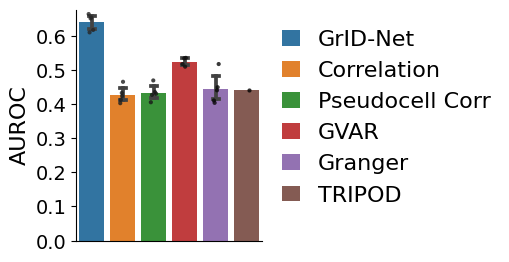

In [35]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['group_corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['gvar.trial{}'.format(trial_no) for trial_no in range(2,6)]
method_list += ['granger.trial{}'.format(trial_no) for trial_no in range(1,6)]

# method_list += ['ABC.score'] #,'dist_ranks']
method_list += ["tripod"]

feature = 'eqtl.all'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

results_df['method'] = [convert_name(n) for n in results_df['method']]
plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)
plt.rcParams['hatch.linewidth'] = 2
# ax.patches[-1].set_edgecolor(ax.patches[-2]._facecolor)
# ax.patches[-1].set_facecolor('white')
# ax.patches[-1].set_hatch('//')
# ax.patches[-1].set_linewidth(2)
    
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
# plt.legend(bbox_to_anchor=(1,1),fontsize=16,frameon=False,handlelength=0.8)
# sns.despine()

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','updated.{}.eqtl.tripod.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
plt.show()

